In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm 

import deepinv as dinv
from tp6.guided_diffusion.unet import create_model
ffhq_model_path = 'tp6/ffhq_10m.pt'

import warnings
warnings.filterwarnings("ignore")
from importlib import reload

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

c:\Users\eliot\AppData\Local\anaconda3\envs\pytorch_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from models_diffusion import DDPMPNP, DPS
from utils import viewimage, A, f
import perform_algorithm as pfa
import utils
from metrics import psnr
reload(pfa)
reload(utils)
import models_diffusion
reload(models_diffusion)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\eliot\AppData\Local\anaconda3\envs\pytorch_env\lib\site-packages\lpips\weights\v0.1\alex.pth


<module 'models_diffusion' from 'c:\\Users\\eliot\\OneDrive\\Documents\\3A\\PRIM\\tp mva\\models_diffusion.py'>

In [3]:
model_config = {'image_size': 256,
                'num_channels': 128,
                'num_res_blocks': 1,
                'channel_mult': '',
                'learn_sigma': True,
                'class_cond': False,
                'use_checkpoint': False,
                'attention_resolutions': 16,
                'num_heads': 4,
                'num_head_channels': 64,
                'num_heads_upsample': -1,
                'use_scale_shift_norm': True,
                'dropout': 0.0,
                'resblock_updown': True,
                'use_fp16': False,
                'use_new_attention_order': False,
                'model_path': ffhq_model_path}

model = create_model(**model_config)
model = model.to(device)
model.eval()


UNetModel(
  (time_embed): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): SiLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
  )
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 128, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (h_upd): Identity()
        (x_upd): Identity()
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=512, out_features=256, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(32, 128, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Dropout(p=0.0, inplace=False)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stri

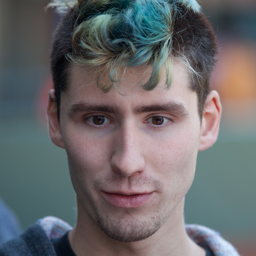

In [4]:
is_csbd68 = False
batch_size = 50

if not is_csbd68:
    directory = 'C:\\Users\\eliot\\OneDrive\\Documents\\3A\\PRIM\\tp mva\\tp6\\ffhq256-1k-validation'
    image_path = f"{directory}\\00015.png"
else:
    directory = 'C:\\Users\\eliot\\OneDrive\\Documents\\3A\\PRIM\\tp mva\\dataset\\train'
    image_path = f"{directory}\\0000.png"

x0 = torch.tensor(plt.imread(image_path), device=device).permute(2, 0, 1).unsqueeze(0)

if is_csbd68:
    x0 = x0[:, :, 60:316, 175:431]  

C, M, N = x0.shape[1:]
batch_tensor = utils.load_batch_images(directory, device, batch_size=batch_size, is_cbsd68=is_csbd68)

viewimage(x0, z=1)

In [5]:
kt = torch.tensor(np.loadtxt('tp8/kernels/levin4.txt'))
# kt = torch.tensor(np.loadtxt('tp8/kernels/kernel4.txt'))
fk = utils.load_kernel(kt, M, N, device)
nu = .01

In [ ]:
directory = 'C:\\Users\\eliot\\OneDrive\\Documents\\3A\\PRIM\\tp mva\\tp6\\ffhq256-1k-validation'
image_path = f"{directory}\\00015.png"
x0 = torch.tensor(plt.imread(image_path), device=device).permute(2, 0, 1).unsqueeze(0)
x1 = torch.tensor(plt.imread(f"{directory}\\00009.png"), device=device).permute(2, 0, 1).unsqueeze(0)


C, M, N = x0.shape[1:]

kt = torch.tensor(np.loadtxt('tp8/kernels/levin4.txt'))
fk = utils.load_kernel(kt, M, N, device)
nu = .01
y0 = A(x0, fk) + nu * torch.randn_like(x0)
y1 = A(x1, fk) + nu * torch.randn_like(x1)

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(x0.squeeze().permute(1, 2, 0).cpu().numpy())
plt.title('Real Image 1')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(x1.squeeze().permute(1, 2, 0).cpu().numpy())
plt.title('Real Image 2')
plt.axis('off')
plt.subplot(2, 2, 3)
plt.imshow(y0.squeeze().permute(1, 2, 0).cpu().numpy())
plt.title('Blurry Image 1')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(y1.squeeze().permute(1, 2, 0).cpu().numpy())
plt.title('Blurry Image 2')
plt.axis('off')

plt.tight_layout()
plt.savefig('real_and_blurry_images.png')


### **Convergence test**
---


#### **Face 1: Test**

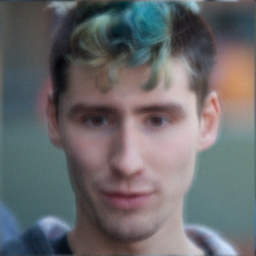

In [43]:
y = A(x0, fk) + nu * torch.randn_like(x0)
viewimage(y, z=1)

In [14]:
drunet = dinv.models.DRUNet(pretrained='tp8/ckpts/drunet_color.pth').to(device)
DDPM = DDPMPNP(model)
n_iter = 800

##### **DRUNET**

In [ ]:
x, metrics, images = pfa.perform_pnp_pgd(x0, y, drunet, fk, nu, n_iter=n_iter,titre='drunet_face_001_800iter')
utils.save_metrics(metrics, 'drunet_face_001_800iter_metrics')

##### **DDPM without relaxation**

In [45]:
x, metrics, images = pfa.perform_pnp_pgd(x0, y, DDPM, fk, nu, n_iter=n_iter,is_ddpm=True, titre='DDPM_face_001_800iter')
utils.save_metrics(metrics, 'DDPM_face_001_800iter_metrics')

  1%|          | 7/800 [00:01<01:40,  7.87it/s]

tensor(-0.0271, device='cuda:0') tensor(0.9867, device='cuda:0') tensor(0.4161, device='cuda:0')


 35%|███▌      | 282/800 [00:34<01:02,  8.29it/s]


KeyboardInterrupt: 

##### **DDPM with relaxation**

In [ ]:
x, metrics, images = pfa.perform_pnp_pgd(x0, y, DDPM, fk, nu, n_iter=n_iter,is_ddpm=True, relax = 0.3,  titre='DDPM_face_001_800iter_relax03')
utils.save_metrics(metrics, 'DDPM_face_001_800iter_metrics_relax03')

##### **PnP-Drunet stochastic**

**Noise level: 0.01**

In [ ]:
x, metrics, images = pfa.perform_pnp_pgd_stochastic(x0, y, drunet, fk, nu, n_iter=n_iter, noise = 0.01, titre='drunet_face_001_800iter_stochastic_nl001')
utils.save_metrics(metrics, 'drunet_face_001_800iter_stochastic_metrics_nl_001')


**Noise level: 0.05**

In [ ]:
x, metrics, images = pfa.perform_pnp_pgd_stochastic(x0, y, drunet, fk, nu, n_iter=n_iter, noise = 0.05, titre='drunet_face_001_800iter_stochastic_nl005')
utils.save_metrics(metrics, 'drunet_face_001_800iter_stochastic_metrics_nl_005')

**Noise level: 0.001**

In [ ]:
x, metrics, images = pfa.perform_pnp_pgd_stochastic(x0, y, drunet, fk, nu, n_iter=n_iter, noise = 0.001, titre='drunet_face_001_800iter_stochastic_nl0001')
utils.save_metrics(metrics, 'drunet_face_001_800iter_stochastic_metrics_nl_0001')

**Noise level: 0.02**

In [ ]:
x, metrics, images = pfa.perform_pnp_pgd_stochastic(x0, y, drunet, fk, nu, n_iter=n_iter, noise = 0.02, titre='drunet_face_001_800iter_stochastic_nl002')
utils.save_metrics(metrics, 'drunet_face_001_800iter_stochastic_metrics_nl_002')

##### **PnP-DDPM stochastic**

**Noise level: 0.05**

In [ ]:
x, metrics, images = pfa.perform_pnp_pgd_stochastic(x0, y, DDPM, fk, nu, n_iter=n_iter, noise = 0.05, is_ddpm = True,  titre='ddpm_face_001_800iter_stochastic_nl005')
utils.save_metrics(metrics, 'ddpm_face_001_800iter_stochastic_metrics_nl_005')

**Noise level: 0.02**

In [ ]:
x, metrics, images = pfa.perform_pnp_pgd_stochastic(x0, y, DDPM, fk, nu, n_iter=n_iter, noise = 0.02, is_ddpm = True,  titre='ddpm_face_001_800iter_stochastic_nl002')
utils.save_metrics(metrics, 'ddpm_face_001_800iter_stochastic_metrics_nl_002')

**Noise level: 0.01**

In [ ]:
x, metrics, images = pfa.perform_pnp_pgd_stochastic(x0, y, DDPM, fk, nu, n_iter=n_iter, noise = 0.01, is_ddpm = True,  titre='ddpm_face_001_800iter_stochastic_nl001')
utils.save_metrics(metrics, 'ddpm_face_001_800iter_stochastic_metrics_nl_001')

**Noise level: 0.001**

In [ ]:
x, metrics, images = pfa.perform_pnp_pgd_stochastic(x0, y, DDPM, fk, nu, n_iter=n_iter, noise = 0.001, is_ddpm = True,  titre='ddpm_face_001_800iter_stochastic_nl0001')
utils.save_metrics(metrics, 'ddpm_face_001_800iter_stochastic_metrics_nl_0001')

#### **Face 2: Test**

In [ ]:
image_path = f"{directory}\\00009.png"
x0 = torch.tensor(plt.imread(image_path), device=device).permute(2, 0, 1).unsqueeze(0)
y = A(x0, fk) + nu * torch.randn_like(x0)
viewimage(y, z=1)

##### **DRUNET**

In [ ]:
x, metrics, images = pfa.perform_pnp_pgd(x0, y, drunet, fk, nu, n_iter=n_iter,titre='drunet_face2_001_800iter')
utils.save_metrics(metrics, 'drunet_face2_001_800iter_metrics')

##### **DDPM without relaxation**

In [ ]:
x, metrics, images = pfa.perform_pnp_pgd(x0, y, DDPM, fk, nu, n_iter=n_iter,is_ddpm=True, titre='DDPM_face2_001_800iter')
utils.save_metrics(metrics, 'DDPM_face2_001_800iter_metrics')

##### **DDPM with relaxation**

In [ ]:
x, metrics, images = pfa.perform_pnp_pgd(x0, y, DDPM, fk, nu, n_iter=n_iter,is_ddpm=True, relax = 0.3,  titre='DDPM_face2_001_800iter_relax03')
utils.save_metrics(metrics, 'DDPM_face2_001_800iter_metrics_relax03')

##### **PnP-Drunet stochastic**

**Noise level: 0.05**  
**Noise level: 0.02**  
**Noise level: 0.01**  
**Noise level: 0.001**  

In [ ]:
x, metrics, images = pfa.perform_pnp_pgd_stochastic(x0, y, drunet, fk, nu, n_iter=n_iter, noise = 0.05, titre='drunet_face2_001_800iter_stochastic_nl005')
utils.save_metrics(metrics, 'drunet_face2_001_800iter_stochastic_metrics_nl_005')

x, metrics, images = pfa.perform_pnp_pgd_stochastic(x0, y, drunet, fk, nu, n_iter=n_iter, noise = 0.02, titre='drunet_face2_001_800iter_stochastic_nl002')
utils.save_metrics(metrics, 'drunet_face2_001_800iter_stochastic_metrics_nl_002')

x, metrics, images = pfa.perform_pnp_pgd_stochastic(x0, y, drunet, fk, nu, n_iter=n_iter, noise = 0.01, titre='drunet_face2_001_800iter_stochastic_nl001')
utils.save_metrics(metrics, 'drunet_face2_001_800iter_stochastic_metrics_nl_001')

x, metrics, images = pfa.perform_pnp_pgd_stochastic(x0, y, drunet, fk, nu, n_iter=n_iter, noise = 0.001, titre='drunet_face2_001_800iter_stochastic_nl0001')
utils.save_metrics(metrics, 'drunet_face2_001_800iter_stochastic_metrics_nl_0001')

##### **PnP-DDPM stochastic**

**Noise level: 0.05**  
**Noise level: 0.02**  
**Noise level: 0.01**  
**Noise level: 0.001**  

In [ ]:
x, metrics, images = pfa.perform_pnp_pgd_stochastic(x0, y, DDPM, fk, nu, n_iter=n_iter, noise = 0.05, is_ddpm = True,  titre='ddpm_face2_001_800iter_stochastic_nl005')
utils.save_metrics(metrics, 'ddpm_face2_001_800iter_stochastic_metrics_nl_005')

x, metrics, images = pfa.perform_pnp_pgd_stochastic(x0, y, DDPM, fk, nu, n_iter=n_iter, noise = 0.02, is_ddpm = True,  titre='ddpm_face2_001_800iter_stochastic_nl002')
utils.save_metrics(metrics, 'ddpm_face2_001_800iter_stochastic_metrics_nl_002')

x, metrics, images = pfa.perform_pnp_pgd_stochastic(x0, y, DDPM, fk, nu, n_iter=n_iter, noise = 0.01, is_ddpm = True,  titre='ddpm_face2_001_800iter_stochastic_nl001')
utils.save_metrics(metrics, 'ddpm_face2_001_800iter_stochastic_metrics_nl_001')

x, metrics, images = pfa.perform_pnp_pgd_stochastic(x0, y, DDPM, fk, nu, n_iter=n_iter, noise = 0.001, is_ddpm = True,  titre='ddpm_face2_001_800iter_stochastic_nl0001')
utils.save_metrics(metrics, 'ddpm_face2_001_800iter_stochastic_metrics_nl_0001')

#### **2000 iterations**
---

In [ ]:
image_path = f"{directory}\\00015.png"
x0 = torch.tensor(plt.imread(image_path), device=device).permute(2, 0, 1).unsqueeze(0)
y = A(x0, fk) + nu * torch.randn_like(x0)
n_iter = 2000

x, metrics, images = pfa.perform_pnp_pgd(x0, y, drunet, fk, nu, n_iter=n_iter,titre='drunet_2000it')
utils.save_metrics(metrics, 'drunet_2000it_metrics')

x, metrics, images = pfa.perform_pnp_pgd(x0, y, DDPM, fk, nu, n_iter=n_iter,is_ddpm=True, titre='DDPM_2000it')
utils.save_metrics(metrics, 'ddpm_2000it_metrics')

x, metrics, images = pfa.perform_pnp_pgd(x0, y, DDPM, fk, nu, n_iter=n_iter,is_ddpm=True, relax = 0.3,  titre='DDPM_2000it_relax03')
utils.save_metrics(metrics, 'DDPM_2000it_metrics_relax03')

x, metrics, images = pfa.perform_pnp_pgd_stochastic(x0, y, drunet, fk, nu, n_iter=n_iter, noise = 0.01, titre='drunet_2000it_stochastic_nl001')
utils.save_metrics(metrics, 'drunet_2000it_stochastic_metrics_nl_001')

x, metrics, images = pfa.perform_pnp_pgd_stochastic(x0, y, DDPM, fk, nu, n_iter=n_iter, noise = 0.01, is_ddpm = True,  titre='ddpm_face_001_2000it_stochastic_nl001')
utils.save_metrics(metrics, 'ddpm_2000it_stochastic_metrics_nl_001')


image_path = f"{directory}\\00009.png"
x0 = torch.tensor(plt.imread(image_path), device=device).permute(2, 0, 1).unsqueeze(0)
y = A(x0, fk) + nu * torch.randn_like(x0)


x, metrics, images = pfa.perform_pnp_pgd(x0, y, drunet, fk, nu, n_iter=n_iter,titre='drunet_2000it_face2')
utils.save_metrics(metrics, 'drunet_2000it_metrics_face2')

x, metrics, images = pfa.perform_pnp_pgd(x0, y, DDPM, fk, nu, n_iter=n_iter,is_ddpm=True, titre='DDPM_2000it_face2')
utils.save_metrics(metrics, 'ddpm_2000it_metrics_face2')

x, metrics, images = pfa.perform_pnp_pgd(x0, y, DDPM, fk, nu, n_iter=n_iter,is_ddpm=True, relax = 0.3,  titre='DDPM_2000it_relax03_face2')
utils.save_metrics(metrics, 'DDPM_2000it_metrics_relax03_face2')

x, metrics, images = pfa.perform_pnp_pgd_stochastic(x0, y, drunet, fk, nu, n_iter=n_iter, noise = 0.01, titre='drunet_2000it_stochastic_nl001_face2')
utils.save_metrics(metrics, 'drunet_2000it_stochastic_metrics_nl_001_face2')

x, metrics, images = pfa.perform_pnp_pgd_stochastic(x0, y, DDPM, fk, nu, n_iter=n_iter, noise = 0.01, is_ddpm = True,  titre='ddpm_face2_001_2000it_stochastic_nl001')
utils.save_metrics(metrics, 'ddpm_2000it_stochastic_metrics_nl_001_face2')

#### **Same face different noise**


In [ ]:
image_path = f"{directory}\\00009.png"
x0 = torch.tensor(plt.imread(image_path), device=device).permute(2, 0, 1).unsqueeze(0)

In [ ]:
torch.random.manual_seed(0)
y = A(x0, fk) + nu * torch.randn_like(x0)

x, metrics, images = pfa.perform_pnp_pgd(x0, y, DDPM, fk, nu, n_iter=n_iter,is_ddpm=True, titre='ddpm_robust_800it_n1')
utils.save_metrics(metrics, 'ddpm_robust_800it_metrics_n1')

x, metrics, images = pfa.perform_pnp_pgd(x0, y, DDPM, fk, nu, n_iter=n_iter,is_ddpm=True, relax = 0.3,  titre='ddpm_robust_800it_n1_relax')
utils.save_metrics(metrics, 'ddpm_robust_800it_metrics_n1_relax')

torch.random.manual_seed(1)

y = A(x0, fk) + nu * torch.randn_like(x0)

x, metrics, images = pfa.perform_pnp_pgd(x0, y, DDPM, fk, nu, n_iter=n_iter,is_ddpm=True, titre='ddpm_robust_800it_n2')
utils.save_metrics(metrics, 'ddpm_robust_800it_metrics_n2')

x, metrics, images = pfa.perform_pnp_pgd(x0, y, DDPM, fk, nu, n_iter=n_iter,is_ddpm=True, relax = 0.3,  titre='ddpm_robust_800it_n2_relax')
utils.save_metrics(metrics, 'ddpm_robust_800it_metrics_n2_relax')

torch.random.manual_seed(2)

y = A(x0, fk) + nu * torch.randn_like(x0)

x, metrics, images = pfa.perform_pnp_pgd(x0, y, DDPM, fk, nu, n_iter=n_iter,is_ddpm=True, titre='ddpm_robust_800it_n3')
utils.save_metrics(metrics, 'ddpm_robust_800it_metrics_n3')

x, metrics, images = pfa.perform_pnp_pgd(x0, y, DDPM, fk, nu, n_iter=n_iter,is_ddpm=True, relax = 0.3,  titre='ddpm_robust_800it_n3_relax')
utils.save_metrics(metrics, 'ddpm_robust_800it_metrics_n3_relax')

### **Experiment:**
---


1. Compute the lipschitz constant for each model depending on a and t.

2. We will try numerours experiments to see how the model performs. First, we will increase the number of iterations to check the convergence of all the algorithms
3. Change the noise $\nu$ to see how the algorithms perform
4. Change the dataset
5. Try to infer the best paramter a, t  for ddpm
6. Try to test with SNORE and DPS or $\pi$ GDM

#### **1. Lipschitz constant:**

##### **Let's Compute $\|\frac {D(x) -D(x+ \epsilon)} {\epsilon}\|$**

In [ ]:
is_csbd68 = False
batch_size = 50

if is_csbd68:
    directory = 'C:\\Users\\eliot\\OneDrive\\Documents\\3A\\PRIM\\tp mva\\dataset\\train'
    image_path = f"{directory}\\0000.png"
else:
    directory = 'C:\\Users\\eliot\\OneDrive\\Documents\\3A\\PRIM\\tp mva\\tp6\\ffhq256-1k-validation'
    image_path = f"{directory}\\00015.png"

x0 = torch.tensor(plt.imread(image_path), device=device).permute(2, 0, 1).unsqueeze(0)

if is_csbd68:
    x0 = x0[:, :, 60:316, 175:431]  

C, M, N = x0.shape[1:]
batch_tensor = utils.load_batch_images(directory, device, batch_size=batch_size, is_cbsd68=is_csbd68)


In [ ]:
nu = .01
x0 = torch.tensor(plt.imread('C:\\Users\\eliot\\OneDrive\\Documents\\3A\\PRIM\\tp mva\\tp6\\ffhq256-1k-validation\\00042.png'), device = device).permute(2,0,1).unsqueeze(0)
x1 = torch.tensor(plt.imread('C:\\Users\\eliot\\OneDrive\\Documents\\3A\\PRIM\\tp mva\\tp6\\ffhq256-1k-validation\\00039.png'), device = device).permute(2,0,1).unsqueeze(0)
noise0, noise1 = nu*torch.randn_like(x0), nu*torch.randn_like(x1)
y0, y1 = x0 + noise0, x1 + noise1

ddx0, ddy0 = DDPM.denoise_step(x0, t=1, a = 1), DDPM.denoise_step(y0, t=1, a = 1).detach()
ddx1, ddy1 = DDPM.denoise_step(x1, t=1, a = 1), DDPM.denoise_step(y1, t=1, a = 1).detach()

drux0, druy0 = drunet(x0, sigma=2*nu), drunet(y0, sigma=2*nu).detach()
drux1, druy1 = drunet(x1, sigma=2*nu), drunet(y1, sigma=2*nu).detach()


L0_ddpm = torch.norm(ddy0- ddx0)/ torch.norm(noise0)
L1_ddpm = torch.norm(ddy1- ddx1)/torch.norm(noise1)
L0_drunet = torch.norm(druy0- drux0)/ torch.norm(noise0)
L1_drunet = torch.norm(druy1- drux1)/torch.norm(noise1)

print(f"L0_ddpm = {L0_ddpm}, L1_ddpm = {L1_ddpm}")
print(f"L0_drunet = {L0_drunet}, L1_drunet = {L1_drunet}")

In [ ]:
# compute Lipschitz without blur kernel
nu = .01
drunet_lipschitz_constant = pfa.estimate_lipschitz_constant(drunet, batch_tensor, nu, num_samples = 1,  is_ddpm=False)
ddpm_lipschitz_constant = pfa.estimate_lipschitz_constant(DDPM, batch_tensor, nu, num_samples =1, is_ddpm=True, a=1, t=1)
utils.plot_lipschitz_comparison(ddpm_lipschitz_constant, drunet_lipschitz_constant, 'DDPM', 'Drunet', title='Lipschitz constant comparison between DDPM and DruNet without blur on ffhq dataset')

In [ ]:
# compute Lipschitz with blur kernel
drunet_lipschitz_constant_with_blur = pfa.estimate_lipschitz_constant(drunet, batch_tensor, nu, num_samples=1, is_ddpm=False, A=A, apply_blur=True, fk = fk)
ddpm_lipschitz_constant_with_blur = pfa.estimate_lipschitz_constant(DDPM, batch_tensor, nu, num_samples=1, is_ddpm=True, a=1, t=1, A=A, apply_blur=True, fk=fk)
utils.plot_lipschitz_comparison(ddpm_lipschitz_constant_with_blur, drunet_lipschitz_constant_with_blur, 'DDPM', 'Drunet', title='Lipschitz constant comparison between DDPM and Drunet with blur on ffhq dataset')

In [ ]:
# compare ddpm with different a 
a_values = [0.1, 0.5, 0.9]
lipschitz_constants = []
fig, ax = plt.subplots(1,1, figsize=(10,5))
for a in a_values:
    ddpm_lipschitz_constant = pfa.estimate_lipschitz_constant(DDPM, batch_tensor, nu,num_samples = 1, is_ddpm=True, a=a, t=1)
    lipschitz_constants.append(ddpm_lipschitz_constant)
    ax.hist(ddpm_lipschitz_constant, bins=20, alpha=0.5, label=f'a = {a}')
ax.legend()
ax.set_title('Lipschitz constant comparison between DDPM with different a values')
plt.savefig('lipschitz_constant_comparison_ddpm_a_values_csbd68.png')
plt.show()


##### **Let's Compute $\|\frac {\xi_{x+eps}  - \xi_{x}} {\epsilon}\|$**

In [ ]:
a_values = [0.1, 0.3, 0.5, 0.9]
lipschitz_constants = []
fig, ax = plt.subplots(1,1, figsize=(10,5))
for a in a_values:
    ddpm_lipschitz_constant = pfa.estimate_lipschitz_constant_real(DDPM, batch_tensor, nu,num_samples = 1, is_ddpm = True,  a=a, t=1)
    lipschitz_constants.append(ddpm_lipschitz_constant)
    ax.hist(ddpm_lipschitz_constant, bins=20, alpha=0.5, label=f'a = {a}')
ax.legend()
ax.set_title('Lipschitz constant comparison between DDPM with different a values')
plt.savefig('lipschitz_constant_comparison_ddpm_a_values_ffhq_2.png')
plt.show()


In [ ]:
drunet_lipschitz_constant = pfa.estimate_lipschitz_constant_real(drunet, batch_tensor, nu, num_samples = 1,  is_ddpm=False)
ddpm_lipschitz_constant = pfa.estimate_lipschitz_constant_real(DDPM, batch_tensor, nu, num_samples =1, is_ddpm=True, a=1, t=1)
utils.plot_lipschitz_comparison(ddpm_lipschitz_constant, drunet_lipschitz_constant, 'DDPM', 'Drunet', title='Lipschitz constant comparison between DDPM and DruNet without blur on ffhq dataset real')

In [ ]:
drunet_lipschitz_constant_with_blur = pfa.estimate_lipschitz_constant_real(drunet, batch_tensor, nu, num_samples=1, is_ddpm=False, A=A, apply_blur=True, fk = fk)
ddpm_lipschitz_constant_with_blur = pfa.estimate_lipschitz_constant_real(DDPM, batch_tensor, nu, num_samples=1, is_ddpm=True, a=1, t=1, A=A, apply_blur=True, fk=fk)
utils.plot_lipschitz_comparison(ddpm_lipschitz_constant_with_blur, drunet_lipschitz_constant_with_blur, 'DDPM', 'Drunet', title='Lipschitz constant comparison between DDPM and Drunet with blur on ffhq dataset 2')

#### **2. Test the deblurring capacity of the denoiser**

In [ ]:
is_csbd68 = False
batch_size = 50

if is_csbd68:
    directory = 'C:\\Users\\eliot\\OneDrive\\Documents\\3A\\PRIM\\tp mva\\dataset\\train'
    image_path = f"{directory}\\0000.png"
else:
    directory = 'C:\\Users\\eliot\\OneDrive\\Documents\\3A\\PRIM\\tp mva\\tp6\\ffhq256-1k-validation'
    image_path = f"{directory}\\00015.png"

x0 = torch.tensor(plt.imread(image_path), device=device).permute(2, 0, 1).unsqueeze(0)

if is_csbd68:
    x0 = x0[:, :, 60:316, 175:431]  

C, M, N = x0.shape[1:]
batch_tensor = utils.load_batch_images(directory, device, batch_size=batch_size, is_cbsd68=is_csbd68)


In [ ]:
nus = [0, 0.01, 0.02, 0.05, 0.1]
img = batch_tensor[49].unsqueeze(0)

fig_images, axes = plt.subplots(len(nus), 3, figsize=(15, 5 * len(nus)))
fig_images.suptitle('Denoising Results for Different Noise Levels')

for i, nu in enumerate(nus):
    y = img + nu * torch.randn_like(img)

    if nu == 0:
        debl_drunet, psnr_val_drunet, lpips_drunet, ssim_val_drunet = pfa.deblurring(img, y, drunet, nu=0.01)
        debl_ddpm, psnr_val_ddpm, lpips_ddpm, ssim_val_ddpm = pfa.deblurring(img, y, DDPM, nu=0.01, is_ddpm=True, t=0)
    else:
        debl_drunet, psnr_val_drunet, lpips_drunet, ssim_val_drunet = pfa.deblurring(img, y, drunet, nu=nu)
        if nu == 0.01:
            debl_ddpm, psnr_val_ddpm, lpips_ddpm, ssim_val_ddpm = pfa.deblurring(img, y, DDPM, nu=nu, is_ddpm=True, t=1)
        elif nu == 0.02:
            debl_ddpm, psnr_val_ddpm, lpips_ddpm, ssim_val_ddpm = pfa.deblurring(img, y, DDPM, nu=nu, is_ddpm=True, t=3)
        elif nu == 0.05:
            debl_ddpm, psnr_val_ddpm, lpips_ddpm, ssim_val_ddpm = pfa.deblurring(img, y, DDPM, nu=nu, is_ddpm=True, t=7)
        elif nu == 0.1:
            debl_ddpm, psnr_val_ddpm, lpips_ddpm, ssim_val_ddpm = pfa.deblurring(img, y, DDPM, nu=nu, is_ddpm=True, t=28)

    last_drunet = debl_drunet
    last_ddpm = debl_ddpm

    # Plot the noisy image
    axes[i, 0].imshow(y.squeeze().cpu().numpy().transpose(1, 2, 0).clip(0, 1))
    axes[i, 0].set_title(f'Noisy (nu={nu})\nPSNR: {psnr(img, y):.2f}')
    axes[i, 0].axis('off')

    # Plot the DRUNet result
    axes[i, 1].imshow(last_drunet.squeeze().cpu().numpy().transpose(1, 2, 0).clip(0, 1))
    axes[i, 1].set_title(f'DRUNet (nu={nu})\nPSNR: {psnr_val_drunet:.2f}')
    axes[i, 1].axis('off')

    # Plot the DDPM result
    axes[i, 2].imshow(last_ddpm.squeeze().cpu().numpy().transpose(1, 2, 0).clip(0, 1))
    axes[i, 2].set_title(f'DDPM (nu={nu})\nPSNR: {psnr_val_ddpm:.2f}')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.savefig('denoising_results_face1.png')
plt.show()

In [ ]:
nus = [0, 0.01, 0.02, 0.05, 0.1]
img = batch_tensor[45].unsqueeze(0)

fig_images, axes = plt.subplots(len(nus), 3, figsize=(15, 5 * len(nus)))
fig_images.suptitle('Denoising Results for Different Noise Levels')

for i, nu in enumerate(nus):
    y = img + nu * torch.randn_like(img)

    if nu == 0:
        debl_drunet, psnr_val_drunet, lpips_drunet, ssim_val_drunet = pfa.deblurring(img, y, drunet, nu=0.01)
        debl_ddpm, psnr_val_ddpm, lpips_ddpm, ssim_val_ddpm = pfa.deblurring(img, y, DDPM, nu=0.01, is_ddpm=True, t=0)
    else:
        debl_drunet, psnr_val_drunet, lpips_drunet, ssim_val_drunet = pfa.deblurring(img, y, drunet, nu=nu)
        if nu == 0.01:
            debl_ddpm, psnr_val_ddpm, lpips_ddpm, ssim_val_ddpm = pfa.deblurring(img, y, DDPM, nu=nu, is_ddpm=True, t=1)
        elif nu == 0.02:
            debl_ddpm, psnr_val_ddpm, lpips_ddpm, ssim_val_ddpm = pfa.deblurring(img, y, DDPM, nu=nu, is_ddpm=True, t=3)
        elif nu == 0.05:
            debl_ddpm, psnr_val_ddpm, lpips_ddpm, ssim_val_ddpm = pfa.deblurring(img, y, DDPM, nu=nu, is_ddpm=True, t=7)
        elif nu == 0.1:
            debl_ddpm, psnr_val_ddpm, lpips_ddpm, ssim_val_ddpm = pfa.deblurring(img, y, DDPM, nu=nu, is_ddpm=True, t=28)

    last_drunet = debl_drunet
    last_ddpm = debl_ddpm

    # Plot the noisy image
    axes[i, 0].imshow(y.squeeze().cpu().numpy().transpose(1, 2, 0).clip(0, 1))
    axes[i, 0].set_title(f'Noisy (nu={nu})\nPSNR: {psnr(img, y):.2f}')
    axes[i, 0].axis('off')

    # Plot the DRUNet result
    axes[i, 1].imshow(last_drunet.squeeze().cpu().numpy().transpose(1, 2, 0).clip(0, 1))
    axes[i, 1].set_title(f'DRUNet (nu={nu})\nPSNR: {psnr_val_drunet:.2f}')
    axes[i, 1].axis('off')

    # Plot the DDPM result
    axes[i, 2].imshow(last_ddpm.squeeze().cpu().numpy().transpose(1, 2, 0).clip(0, 1))
    axes[i, 2].set_title(f'DDPM (nu={nu})\nPSNR: {psnr_val_ddpm:.2f}')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.savefig('denoising_results_face2.png')
plt.show()

In [ ]:
### Test on two is_csbd68 images

directory = 'C:\\Users\\eliot\\OneDrive\\Documents\\3A\\PRIM\\tp mva\\dataset\\train'
image_path_1 = f"{directory}\\0002.png"
img = torch.tensor(plt.imread(image_path_1), device=device).permute(2, 0, 1).unsqueeze(0)[:,:,:320,:480]

nus = [0, 0.01, 0.02, 0.05, 0.1]

fig_images, axes = plt.subplots(len(nus), 3, figsize=(15, 5 * len(nus)))
fig_images.suptitle('Denoising Results for Different Noise Levels')

for i, nu in enumerate(nus):
    y = img + nu * torch.randn_like(img)
    if nu == 0:
        debl_drunet, psnr_val_drunet, lpips_drunet, ssim_val_drunet = pfa.deblurring(img, y, drunet, nu=0.01)
        debl_ddpm, psnr_val_ddpm, lpips_ddpm, ssim_val_ddpm = pfa.deblurring(img, y, DDPM, nu=0.01, is_ddpm=True, t=0)
    else:
        debl_drunet, psnr_val_drunet, lpips_drunet, ssim_val_drunet = pfa.deblurring(img, y, drunet, nu=nu)
        if nu == 0.01:
            debl_ddpm, psnr_val_ddpm, lpips_ddpm, ssim_val_ddpm = pfa.deblurring(img, y, DDPM, nu=nu, is_ddpm=True, t=1)
        elif nu == 0.02:
            debl_ddpm, psnr_val_ddpm, lpips_ddpm, ssim_val_ddpm = pfa.deblurring(img, y, DDPM, nu=nu, is_ddpm=True, t=3)
        elif nu == 0.05:
            debl_ddpm, psnr_val_ddpm, lpips_ddpm, ssim_val_ddpm = pfa.deblurring(img, y, DDPM, nu=nu, is_ddpm=True, t=7)
        elif nu == 0.1:
            debl_ddpm, psnr_val_ddpm, lpips_ddpm, ssim_val_ddpm = pfa.deblurring(img, y, DDPM, nu=nu, is_ddpm=True, t=28)

    last_drunet = debl_drunet
    last_ddpm = debl_ddpm

    # Plot the noisy image
    axes[i, 0].imshow(y.squeeze().cpu().numpy().transpose(1, 2, 0).clip(0, 1))
    axes[i, 0].set_title(f'Noisy (nu={nu})\nPSNR: {psnr(img, y):.2f}')
    axes[i, 0].axis('off')

    # Plot the DRUNet result
    axes[i, 1].imshow(last_drunet.squeeze().cpu().numpy().transpose(1, 2, 0).clip(0, 1))
    axes[i, 1].set_title(f'DRUNet (nu={nu})\nPSNR: {psnr_val_drunet:.2f}')
    axes[i, 1].axis('off')

    # Plot the DDPM result
    axes[i, 2].imshow(last_ddpm.squeeze().cpu().numpy().transpose(1, 2, 0).clip(0, 1))
    axes[i, 2].set_title(f'DDPM (nu={nu})\nPSNR: {psnr_val_ddpm:.2f}')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.savefig('denoising_results_csbd68_1.png')
plt.show()


In [ ]:
image_path_2 = f"{directory}\\0001.png"
img = torch.tensor(plt.imread(image_path_2), device=device).permute(2, 0, 1).unsqueeze(0)[:,:,:320,:480]

fig_images, axes = plt.subplots(len(nus), 3, figsize=(15, 5 * len(nus)))
fig_images.suptitle('Denoising Results for Different Noise Levels')

for i, nu in enumerate(nus):
    y = img + nu * torch.randn_like(img)

    if nu == 0:
        debl_drunet, psnr_val_drunet, lpips_drunet, ssim_val_drunet = pfa.deblurring(img, y, drunet, nu=0.01)
        debl_ddpm, psnr_val_ddpm, lpips_ddpm, ssim_val_ddpm = pfa.deblurring(img, y, DDPM, nu=0.01, is_ddpm=True, t=0)
    else:
        debl_drunet, psnr_val_drunet, lpips_drunet, ssim_val_drunet = pfa.deblurring(img, y, drunet, nu=nu)
        if nu == 0.01:
            debl_ddpm, psnr_val_ddpm, lpips_ddpm, ssim_val_ddpm = pfa.deblurring(img, y, DDPM, nu=nu, is_ddpm=True, t=1)
        elif nu == 0.02:
            debl_ddpm, psnr_val_ddpm, lpips_ddpm, ssim_val_ddpm = pfa.deblurring(img, y, DDPM, nu=nu, is_ddpm=True, t=3)
        elif nu == 0.05:
            debl_ddpm, psnr_val_ddpm, lpips_ddpm, ssim_val_ddpm = pfa.deblurring(img, y, DDPM, nu=nu, is_ddpm=True, t=7)
        elif nu == 0.1:
            debl_ddpm, psnr_val_ddpm, lpips_ddpm, ssim_val_ddpm = pfa.deblurring(img, y, DDPM, nu=nu, is_ddpm=True, t=28)

    last_drunet = debl_drunet
    last_ddpm = debl_ddpm

    # Plot the noisy image
    axes[i, 0].imshow(y.squeeze().cpu().numpy().transpose(1, 2, 0).clip(0, 1))
    axes[i, 0].set_title(f'Noisy (nu={nu})\nPSNR: {psnr(img, y):.2f}')
    axes[i, 0].axis('off')

    # Plot the DRUNet result
    axes[i, 1].imshow(last_drunet.squeeze().cpu().numpy().transpose(1, 2, 0).clip(0, 1))
    axes[i, 1].set_title(f'DRUNet (nu={nu})\nPSNR: {psnr_val_drunet:.2f}')
    axes[i, 1].axis('off')

    # Plot the DDPM result
    axes[i, 2].imshow(last_ddpm.squeeze().cpu().numpy().transpose(1, 2, 0).clip(0, 1))
    axes[i, 2].set_title(f'DDPM (nu={nu})\nPSNR: {psnr_val_ddpm:.2f}')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.savefig('denoising_results_csbd68_2.png')
plt.show()

#### **3. DPS SNORE**

In [22]:
image_path0, image_path1 = f"{directory}\\00015.png", f"{directory}\\00009.png"
x0 = torch.tensor(plt.imread(image_path0), device=device).permute(2, 0, 1).unsqueeze(0)
x1 = torch.tensor(plt.imread(image_path1), device=device).permute(2, 0, 1).unsqueeze(0)
y0, y1 = A(x0, fk) + nu * torch.randn_like(x0), A(x1, fk) + nu * torch.randn_like(x1)
dps = DPS(model)

  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration = 999


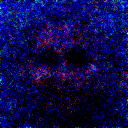

 10%|▉         | 99/1000 [00:22<03:18,  4.55it/s]

Iteration = 900


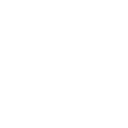

 20%|█▉        | 199/1000 [00:44<03:18,  4.03it/s]

Iteration = 800


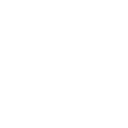

 30%|██▉       | 299/1000 [01:07<02:33,  4.56it/s]

Iteration = 700


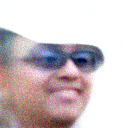

 40%|███▉      | 399/1000 [01:30<02:16,  4.40it/s]

Iteration = 600


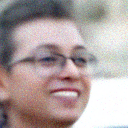

 50%|████▉     | 499/1000 [01:52<01:51,  4.49it/s]

Iteration = 500


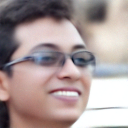

 60%|█████▉    | 599/1000 [02:15<01:29,  4.50it/s]

Iteration = 400


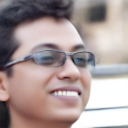

 69%|██████▉   | 691/1000 [02:35<01:11,  4.32it/s]

In [ ]:
final_img0 = dps.posterior_sampling(A, y1, fk,  x_true = x1)

100%|██████████| 400/400 [00:48<00:00,  8.32it/s]


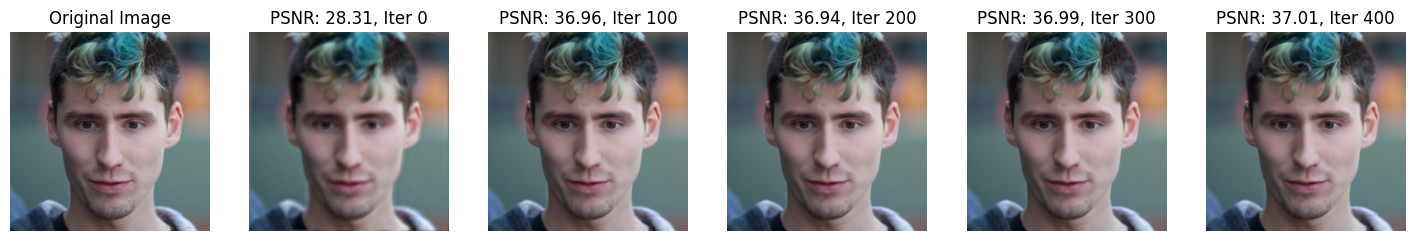

In [ ]:
x, metrics, images = pfa.perform_pnp_pgd_stochastic(x1, y1, DDPM, fk, nu, n_iter=400, noise = 0.01, is_ddpm = True,  titre='ddpm_face_001_800iter_stochastic_nl001')

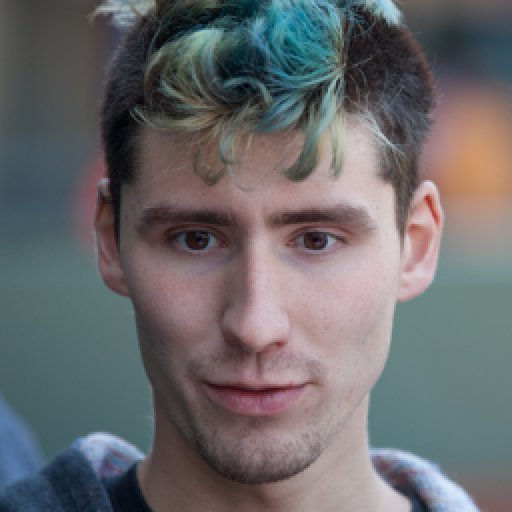

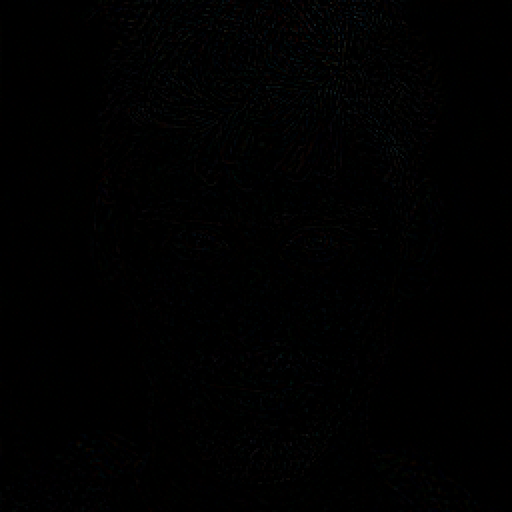

37.01344520275888


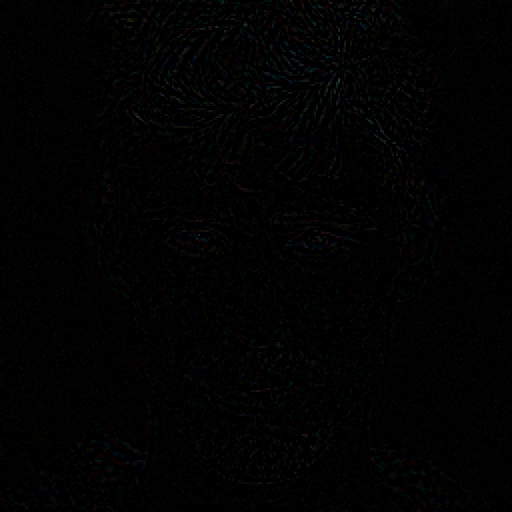

34.44769173399188


In [ ]:
viewimage(x1)
viewimage(x-x1)
print(psnr(x1, x))
viewimage(final_img0-x1)
print(psnr(final_img0, x1))

In [ ]:
m = 16  # Number of annealing levels
sigma_0 = 1.8 * nu  # Initial noise level
sigma_m1 = 0.5 * nu  # Final noise level
alpha_0 = 0.1 * sigma_0**2 / nu**2  # Initial alpha
alpha_m1 = sigma_m1**2 / nu**2 # Final alpha
viewimage(x1, z=1)
x_restored, metrics, images = pfa.perform_annealed_snore(x1, drunet, fk, n_iter=1500, nu=nu, 
                                                     sigma_0=sigma_0, sigma_m1=sigma_m1, 
                                                     alpha_0=alpha_0, alpha_m1=alpha_m1, 
                                                     m=m, f=f, A=A, titre='snore_deblurring_face')

In [ ]:
x_restored, metrics, images = pfa.perform_annealed_snore(x0, drunet, fk, n_iter=1500, nu=nu, 
                                                     sigma_0=sigma_0, sigma_m1=sigma_m1, 
                                                     alpha_0=alpha_0, alpha_m1=alpha_m1, 
                                                     m=m, f=f, A=A, titre='snore_deblurring_face')